# NLP on Review Data

This notebook consists of code that will:

1. Import Business Information and Review Data (and subselect data if needed).
2. Create Restaurant and Review objects
3. Condition the Review Data - clean, remove stopwords, tokenize, perform phrase analysis
4. Visualize sentiment by star rating and over time for a business.
5. Perform TFIDF Analysis to get important words/phrases for a business.
6. Perform Word Embedding to further gain insights about business reviews. - visualize embedding space

# Import Python Libraries and My Python Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
import re
import gensim
from gensim.summarization import keywords
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import string
import time

from gensim.models import Phrases
from gensim.models.phrases import Phraser

## Graphing Libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from textblob import TextBlob

# Import My Functions and Classes

In [2]:
from data_queries import business_info_df, reviews_df
from data_queries import get_businesses_by_category
from data_queries import get_reviews_by_category 
from data_queries import get_businesses_by_name
from data_queries import get_reviews_for_businesses
from data_queries import get_subset_list

from data_classes import Review, Restaurant
#from data_classes import clean_text

from data_analysis import get_idf, get_tfidf_scores, dummy_function
from data_analysis import get_polarity_over_time, display_polarity_over_time
from data_analysis import tsne_plot_words

#from data_conditioning import my_tokenizer, clean_text, remove_stopwords, remove_gibberish
#from data_conditioning import gensim_bigram, textblob_polarity, get_polarity_over_time
#from data_conditioning import get_idf, get_tfidf, get_tfidf_vectors, get_tfidf_scores
#from data_conditioning import stopwords

# Downselect Categories and Businesses - Subset

If you want to reduce the amount of data being used, and to reduce file outputs for tableau / github. Downselect the data using the parameters below.

Set boolean variable below:

In [6]:
subset = True #Set TRUE or FALSE

#Set parameters below if using a subset of Data
min_businesses_in_category = 9  #Minimum number of businesses in a category in order to include category
min_reviews_per_business = 100  #Minimum number of reviews for a business in order to include the business
min_reviews_per_category = 1500  #Minimum number of reviews in a category in order to include the category

if subset:
    biz_list, category_list = get_subset_list(min_businesses_in_category, 
                                              min_reviews_per_business, 
                                              min_reviews_per_category)

Burgers               19 places,  3255 reviews
Sandwiches            14 places,  2126 reviews
Italian               19 places,  2951 reviews
Salad                 10 places,  1726 reviews
American New          19 places,  3896 reviews
Japanese              15 places,  2084 reviews
American Traditional  30 places,  5543 reviews
Mexican               10 places,  1875 reviews
Bars                  41 places,  7221 reviews
Sushi Bars            17 places,  2328 reviews
Seafood               14 places,  2767 reviews
Breakfast & Brunch    20 places,  3196 reviews
Pizza                 13 places,  2028 reviews
Pubs                  13 places,  2681 reviews

14 categories.
143 unique businesses represented in these categories.
24345 unique reviews represented in these categories.


### Update dataframe if using subset

In [7]:
if subset:
    print("Original Number of Reviews:", len(reviews_df))
    indices_to_keep = get_reviews_for_businesses(biz_list).index
    indices_to_drop = [index_value for index_value in reviews_df.index if index_value not in indices_to_keep]
    reviews_df.drop(index=indices_to_drop, inplace=True)
    print("New Number of Reviews:", len(reviews_df), "\n")
    
    print("Original Number of Businesses:", len(business_info_df))
    indices_to_keep = business_info_df[[biz in biz_list for biz in business_info_df.biz_id]].index
    indices_to_drop = [index_value for index_value in business_info_df.index if index_value not in indices_to_keep]
    business_info_df.drop(index=indices_to_drop, inplace=True)
    print("New Number of Businesses:", len(business_info_df))
    
    #For making files smaller for tableau or github
    business_info_df.to_csv('csv_files/business_info.csv',index=False)
    reviews_df.to_csv('csv_files/reviews.csv',index=False)

Original Number of Reviews: 59274
New Number of Reviews: 24345 

Original Number of Businesses: 1081
New Number of Businesses: 143


# Initialize Restaurant Objects & Review Objects

Objects are **Restaurant** and **Review** classes defined in `data_classes.py`.

In [8]:
restaurants = []

for idx in business_info_df.index:
    
    #Get Relevant Restaurant Information
    name = business_info_df.name[idx]
    address = business_info_df.address[idx]
    categories = business_info_df.category[idx]
    price_range = business_info_df.price_range[idx]
    star_rating = business_info_df.star_rating[idx]
    business_index = business_info_df.biz_id[idx]
    
    #Create Restaurant Object
    restaurants.append(Restaurant(name, business_index, address, categories, price_range, star_rating))

In [9]:
reviews = []
for idx in reviews_df.index:
    text = reviews_df.review[idx] 
    date = reviews_df.date[idx]
    star_rating = reviews_df.star_rating[idx]
    reviews.append(Review(text, date, star_rating))

# Data Conditioning
Cleaning, Stopword removal, Tokenization, Polarity

### Clean, Tokenize, Assign Polarity

In [10]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False).tokenize

In [11]:
print("Cleaning, Tokenizing, Assigning Polarity:", end=' ')
start = time.time()

for review in reviews:
    review.clean_text()
    review.assign_polarity()
    review.tokenize(tokenizer)
    
end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

Cleaning, Tokenizing, Assigning Polarity: 00:00:40


In [12]:
reviews_df['polarity'] = [review.polarity for review in reviews]

### Polarity versus star rating

24345 reviews used


/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



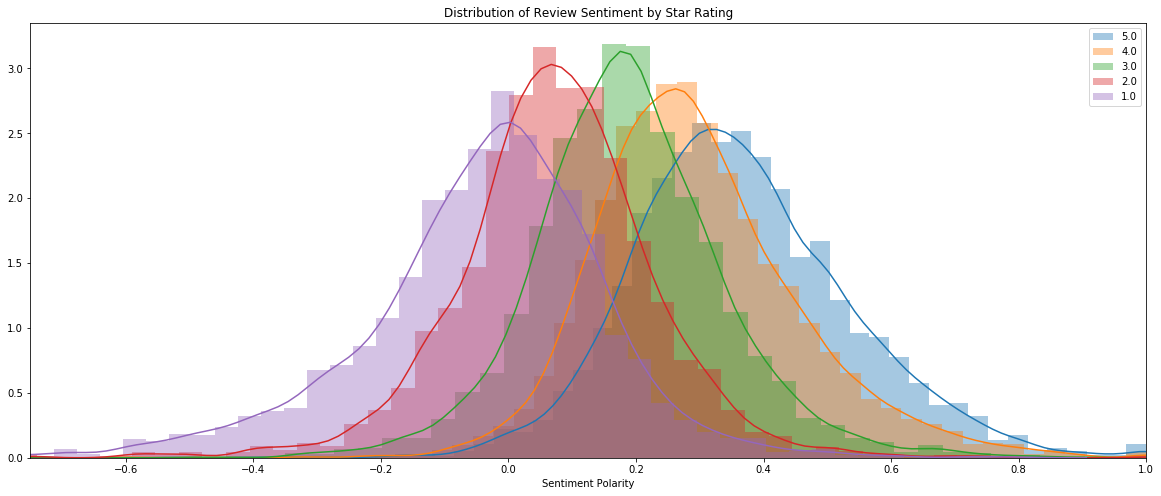

In [13]:
search_term = ''
selected_reviews = get_reviews_by_category(search_term)
print(len(selected_reviews), "reviews used")

ratings = sorted(selected_reviews.star_rating.unique(),reverse=True)
plt.figure(figsize=(20,8))
for rating in ratings:
    sns.distplot(selected_reviews.polarity[selected_reviews.star_rating==rating], kde=True, label=rating)
plt.legend()
plt.xlim((-0.75,1))
plt.xlabel('Sentiment Polarity');
plt.title('Distribution of Review Sentiment by Star Rating');

### Phrasing of Reviews

I did not want phrases to go from the end of a sentence to the beginning of another sentence. Therefore, I treat each sentence as a separate item for phrasing.

In [14]:
#def fit_phraser(sentences, min_count=5, threshold=10, scoring='default'):
def fit_phraser(sentences, min_count=5, threshold=0.25, scoring='npmi'):
    """
    This function returns a gensim bigram phraser. The phraser is fit to the sentences passed in 
    and passes the min_count, threshold, and scoring parameters to Phrases in gensim.models.
    """
    bigram = Phrases(sentences=sentences, min_count=min_count, threshold=threshold, scoring=scoring)
    return Phraser(bigram)

In [15]:
stopwords = nltk.corpus.stopwords.words('english')

In [16]:
for review in reviews:
    #review.remove_stopwords(stopwords)
    review.drop_short_words(2)
    review.drop_short_sentences(1)

**Bigrams**

In [17]:
#GET ALL SENTENCES, THEN FIT A PHRASER
all_sentences = []
for review in reviews:
    all_sentences.extend(review.text)
print(len(all_sentences), "sentences across all reviews.")

191870 sentences across all reviews.


In [18]:
print("Bigram Phrasing:", end=' ')
start = time.time()

bigram_phraser = fit_phraser(all_sentences)
[review.apply_phraser(bigram_phraser) for review in reviews]
all_sentences = [bigram_phraser[sentence] for sentence in all_sentences]

end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

Bigram Phrasing: 00:00:24


**Trigrams**

In [19]:
print("Trigram Phrasing:", end=' ')
start = time.time()

trigram_phraser = fit_phraser(all_sentences)
[review.apply_phraser(trigram_phraser) for review in reviews]

end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

Trigram Phrasing: 00:00:24


### Remove Stopwords

First remove NLTK Corpus Stopwords

In [20]:
stopwords = nltk.corpus.stopwords.words('english')

In [21]:
for review in reviews:
    review.remove_stopwords(stopwords)

See other Common words

In [22]:
tokenized_full_reviews = [review.get_all_tokens() for review in reviews]

In [23]:
def get_word_counts(tokenized_sentences):
    reviews_w2v_model = Word2Vec(tokenized_sentences,size=100,window=5,min_count=1,workers=4)
    words = []
    counts = []
    for word, vocab_obj in reviews_w2v_model.wv.vocab.items():
        words.append(word)
        counts.append(vocab_obj.count)
    df = pd.DataFrame(data=counts,index=words, columns=['word_counts'])
    return df.sort_values(by='word_counts', ascending=False)

Top 20 by word count

In [24]:
top_20_count = get_word_counts(tokenized_full_reviews)[0:20]
print(list(top_20_count.index))

['good', 'great', 'food', 'place', 'ordered', 'one', 'the_food', 'service', 'also', 'like', 'restaurant', 'get', 'got', 'this_place', 'order', 'time', 'delicious', 'really', 'well', 'nice']


Top 20 by IDF weight

In [25]:
top_20_idf = get_idf(tokenized_full_reviews, tokenized=True, ngram_range=(1,1))[0:20]
print(list(top_20_idf.index))

['good', 'great', 'food', 'place', 'the_food', 'ordered', 'one', 'service', 'also', 'like', 'restaurant', 'get', 'this_place', 'delicious', 'time', 'got', 'order', 'really', 'well', 'nice']


In [26]:
additional_stopwords = list(set(list(top_20_count.index) + list(top_20_idf.index)))

In [27]:
for review in reviews:
    review.remove_stopwords(additional_stopwords)
    review.drop_short_words(4)
    #review.drop_short_sentences(1)

### Write tokenized reviews to csv file
Tokenized reviews are needed for machine learning models in rating prediction notebook `Project_Predict_Ratings.ipynb`.

In [28]:
#Add tokenized reviews to csv file for rating predictions notebook
reviews_df['review_tokenized'] = [review.get_all_tokens() for review in reviews]
reviews_df.to_csv('csv_files/reviews.csv',index=False)

### Add Cleaned and Tokenized Review objects to Restaurant obects

In [29]:
reviews_df['review_obj'] = reviews

In [30]:
for restaurant in restaurants:
    selected_reviews = list(reviews_df.review_obj[reviews_df.business_index==restaurant.biz_id])
    restaurant.set_reviews(selected_reviews)

# See Restaurant Sentiment over Time

In [31]:
def get_restaurants(search_term):
    search_results = [rest for rest in restaurants if bool(re.search(search_term, rest.biz_id.lower()))]
    display([rest.biz_id for rest in search_results])
    return search_results

In [32]:
search_term = 'wolffs'

search_results = get_restaurants(search_term)

['Berben And Wolffs Albany', 'Wolffs Biergarten Albany']

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



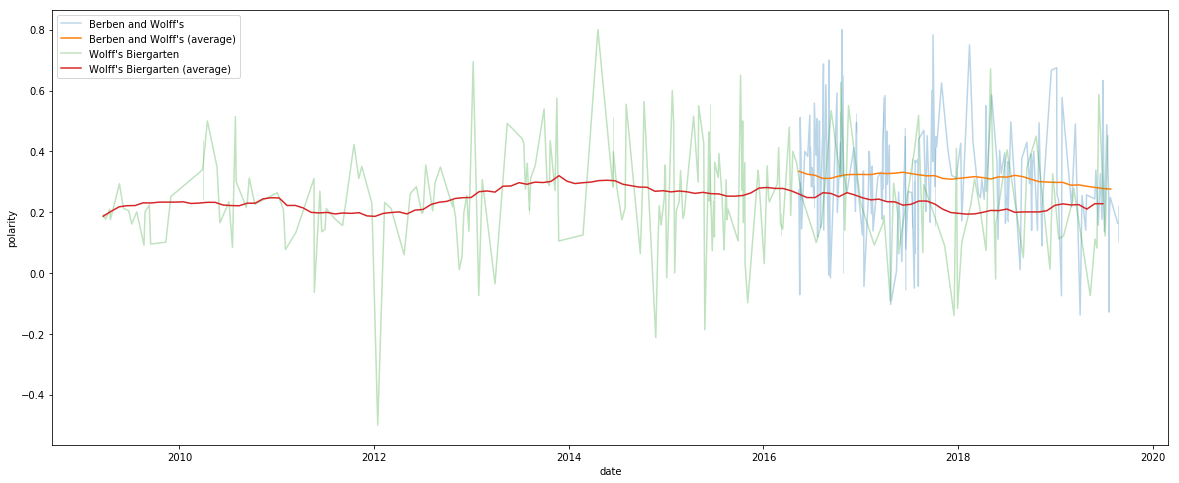

In [33]:
display_polarity_over_time(search_results)

# TF/IDF Analysis

Compare a restaurants reviews to other restaurant reviews in the same categories.
Break down by star rating for each comparison.

In [34]:
#Declare a TfidfVectorizer to be used for TF/IDF analysis
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),
                                   tokenizer=dummy_function,
                                   preprocessor=dummy_function,
                                   token_pattern=None)

In [35]:
n = 50 #Number of key words to store

tfidf_keywords = []

print("TFIDF for Each Restaurant within category:", end=' ')
start = time.time()

#Loop through restaurants
for restaurant in restaurants:

    #Get Categories that restaurant is a part of
    category_list = restaurant.categories
    doc_lists = {5.0:[],4.0:[],3.0:[],2.0:[],1.0:[]}
    
    #Loop through restaurants and determine those that are part of the same categories
    for rest_2 in restaurants:
        if any([rest_2.is_in_category(cat) for cat in category_list]):
            
            #Populate doc lists for each star rating
            for rating in [1,2,3,4,5]:
                doc_lists[rating].append(rest_2.get_document(star_rating=rating))
                
    #Now have doc lists for every star rating within a restaurant's categories
    
    for rating in [1,2,3,4,5]:
        #Fit TFIDF Vectorizer for docs in each star rating
        tfidf_vectorizer.fit(doc_lists[rating])
        
        #Transform original docs for restaurant
        rest_document = restaurant.get_document(star_rating=rating)
        if rest_document:
            results = get_tfidf_scores(tfidf_vectorizer, rest_document)[0:n]
            restaurant.set_keywords(rating, results.index, results.score)
    
    #Get data into a list so that it can be saved to a csv file
    tfidf_keywords.extend(restaurant.get_keywords())
    
end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

TFIDF for Each Restaurant within category: 00:00:49


In [36]:
tfidf_keywords_df = pd.DataFrame(tfidf_keywords)
tfidf_keywords_df['score2'] = (100*tfidf_keywords_df.score)**2
tfidf_keywords_df.head()

,Restaurant Id,score,star_rating,word,score2
0,The Cuckoos Nest Albany,0.227695,1.0,paid_for_caesar_salad,518.449534
1,The Cuckoos Nest Albany,0.227695,1.0,was_super_excited,518.449534
2,The Cuckoos Nest Albany,0.227695,1.0,ice_cubes_our_drinks,518.449534
3,The Cuckoos Nest Albany,0.227695,1.0,caesar_salad,518.449534
4,The Cuckoos Nest Albany,0.227695,1.0,they_offered,518.449534


In [37]:
#WRITE KEYWORDS TO FILE
tfidf_keywords_df.to_csv('tableau_word_tfidf_biz.csv',index=False)

# Word Embedding Analysis

Make word embedding models based on star rating

In [38]:
models = {}
doc_lists = {5.0:[],4.0:[],3.0:[],2.0:[],1.0:[]}
ratings = [1.0,2.0,3.0,4.0,5.0]

for restaurant in restaurants:
    for rating in ratings:
        doc_lists[rating].extend(restaurant.get_review_sentences(star_rating=rating))
        
for rating in ratings:
    print(f"Modeling {rating} ratings:", end=' ')
    start = time.time()
    models[rating] = Word2Vec(doc_lists[rating],size=100,window=5,min_count=1,workers=4)
    models[rating].train(doc_lists[rating],total_examples=models[rating].corpus_count,epochs=10)
    end = time.time()
    print(round(end-start,2), "sec")

Modeling 1.0 ratings: 2.6 sec
Modeling 2.0 ratings: 2.88 sec
Modeling 3.0 ratings: 3.96 sec
Modeling 4.0 ratings: 6.14 sec
Modeling 5.0 ratings: 5.98 sec


In [39]:
#See outputs for a specific word
positive = ['burger', 'wings', 'fries']
negative = []
n_words = 8
n_words_on_plot = 100
for key in sorted(models, reverse=True):
    try:
        print(key,"rating",[w[0] for w in models[key].wv.most_similar(
            positive=positive, negative=negative, topn=n_words)])
    except:
        pass

5.0 rating ['burgers', 'steak', 'gravy', 'french_onion', 'was_cooked_perfectly', "i've_ever_tasted", 'frites', 'cheese']
4.0 rating ['bacon', 'sandwich', 'chili', 'pretzels', 'onions', 'aioli', 'build_your_own', 'heavy']
3.0 rating ['sandwich', 'onions', 'burgers', 'was_very_good', 'taste', 'cooked', 'tasty', 'without']
2.0 rating ['cheese', 'came_out', 'sandwich', 'taste', 'salad', 'bacon', 'burrito', 'plate']
1.0 rating ['nothing', 'cheese', 'fresh', 'husband', 'something', 'another', 'salad', 'sandwich']


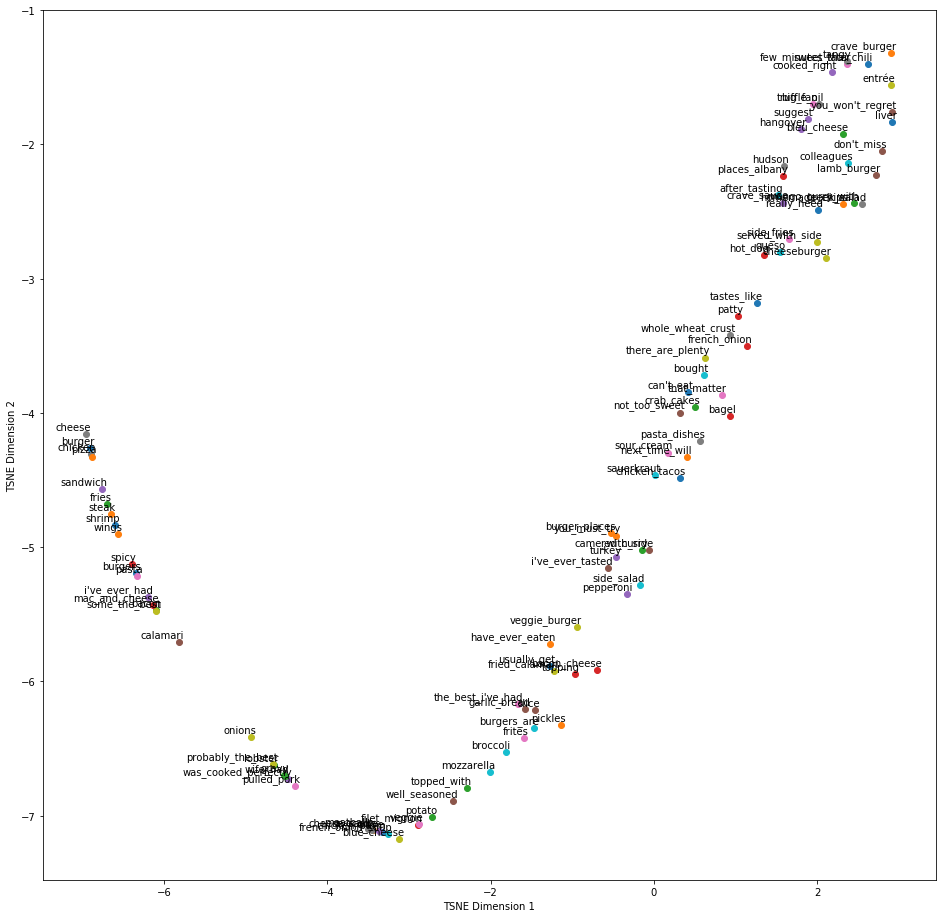

In [40]:
tsne_plot_words(models[5.0], n_words=n_words_on_plot, positive=positive, negative=negative)

Use keywords from a business to see word embedding vectors

In [41]:
search_results = get_restaurants('cuckoos')

['The Cuckoos Nest Albany']

In [42]:
n_words = 8
for restaurant in search_results:
    print(restaurant.biz_id)
    keywords = pd.DataFrame(restaurant.get_keywords())
    keywords.sort_values(by='score', ascending=False, inplace=True)
    for rating in sorted(keywords.star_rating.unique(),reverse=True):
        keywords_10 = list(keywords.word[keywords.star_rating==rating][0:10].values)
        try:
            print(rating,"rating",[w[0] for w in models[rating].wv.most_similar(
                positive=keywords_10, negative=negative, topn=n_words)])
        except:
            pass  
    print("\n")

The Cuckoos Nest Albany
5.0 rating ['sausage', 'seafood', 'nachos', 'garlic', 'home_fries', 'slices', 'entree', 'spinach']
4.0 rating ['risotto', 'garlic', "didn't_like", 'home_fries', 'peppers', 'noodles', 'salty', 'hummus']
3.0 rating ['spicy', 'steak', 'pieces', 'came_with', 'salad', 'pasta', 'salmon', 'vegetables']
2.0 rating ['was_very_good', 'girlfriend', 'choice', 'awful', 'soggy', 'could_not', 'ice_cream', 'there_are_many']
1.0 rating ['crowd', 'boring', 'guests', 'first_time', 'microwave', 'burned', 'diners', 'often']




Restaurant Specific Model

In [43]:
word_embedding_models = {}

print("Restaurant Specific Model:", end=' ')
start = time.time()


#Loop through restaurants
for restaurant in restaurants:             
    #Fit a model to reviews for each restaurants reviews
    sentences = restaurant.get_review_sentences()
    model = Word2Vec(sentences,size=100,window=5,min_count=1,workers=4)
    model.train(sentences,total_examples=models[rating].corpus_count,epochs=10)
        
    word_embedding_models[restaurant.biz_id] = model

end = time.time()
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

Restaurant Specific Model: 00:00:42


In [44]:
search_results = get_restaurants('olive garden')

['Olive Garden Italian Restaurant Colonie 2']

In [45]:
n_words = 8
n_words_on_plot = 100

for restaurant in search_results:
    print(restaurant.biz_id)
    keywords = pd.DataFrame(restaurant.get_keywords())
    keywords.sort_values(by='score', ascending=False, inplace=True)
    for rating in sorted(keywords.star_rating.unique(),reverse=True):
        keywords_10 = list(keywords.word[keywords.star_rating==rating][0:10].values)
        try:
            print(rating,"rating",[w[0] for w in word_embedding_models[restaurant.biz_id].wv.most_similar(
                positive=keywords_10, negative=negative, topn=n_words)])
        except:
            pass 
    print("\n")

Olive Garden Italian Restaurant Colonie 2
5.0 rating ['swearing', 'reasonable', "cook_perfection_that's_where", 'hospital', "i'm_constantly_amazed", 'our_orders', 'street', 'eat_here']
4.0 rating ['eggplant_parmigiana', 'the_bar_knowing_that', 'ravioli', "plus_didn't_come", 'true_italian_restaurants', 'about_inch_thick', 'then_walked_away', 'sandwiches']
3.0 rating ['standard', 'lower_carb_option', 'that_costs_play', 'later', 'served', "came_with_friend's", 'restaurants', 'the_manager']
2.0 rating ['coming_out', 'update', 'bartender', 'combination', 'would_choose', "i'm_not_sure_how", 'orders', 'thank_you_ali']
1.0 rating ['our_arrival', 'put_hold', 'had_use_substitution', 'heated', 'lasagna', "good_ole_a's_more", 'eggplant_parmigiana', 'seems_ridiculous']




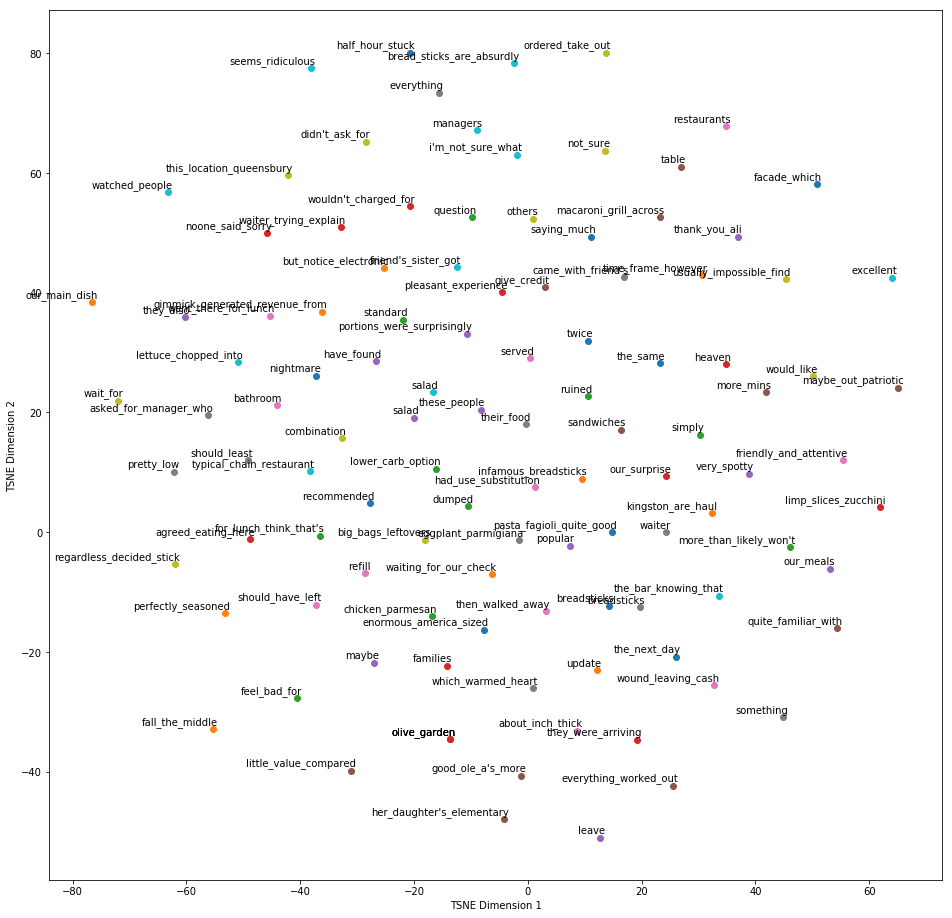

In [46]:
rest = search_results[0]
keywords = pd.DataFrame(rest.get_keywords()).sort_values(by='score', ascending=False)
positive = list(keywords.word[0:10].values)

tsne_plot_words(word_embedding_models[rest.biz_id], n_words=n_words_on_plot, positive=positive, negative=[])